<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 360, lon: 720, time: 12)
Coordinates:
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time      (time) object 2014-01-16 00:00:00 ... 2014-12-16 00:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 -90.0 -89.5 -89.5 -89.0 ... 89.5 89.5 90.0
    lon_bnds  (lon, bnds) float64 -180.0 -179.5 -179.5 ... 179.5 179.5 180.0
    emis_crs  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
<xarray.Dataset>
Dimensions:   (lat: 360, lon: 720, time: 12)
Coordinates:
  * lon       (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat       (lat) float64 -89.75 -89.25 -88.75 -88.25 ... 88.75 89.25 89.75
  * time      (time) object 2014-01-16 00:00:00 ... 2014-12-16 00:00:00
Data variables:
    emis_agr  (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    

C:\Users\conno\anaconda3\lib\site-packages\xarray\core\computation.py:700: RuntimeWarning: divide by zero encountered in log10
  result_data = func(*input_data)


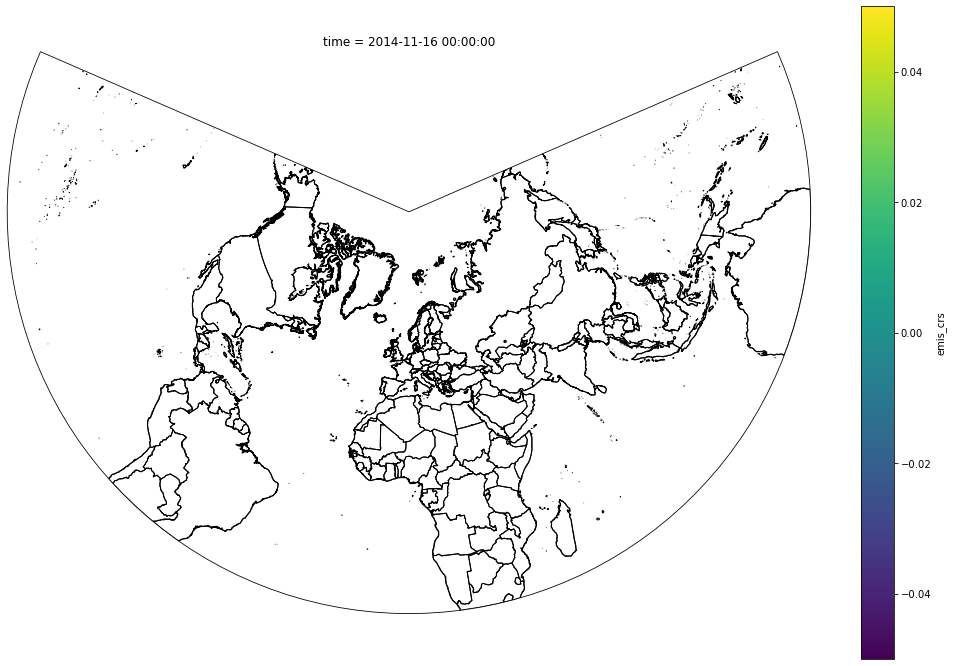

In [18]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
import cartopy.io.shapereader as shpreader
from cartopy.io.shapereader import Reader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.feature import (OCEAN, LAKES, BORDERS, COASTLINE, RIVERS, COLORS,
                             LAND)
import netCDF4

#CMIP6 data has anthropogenic and aircraft emissions as separate files. Import both so they can be combined.
ds = xr.open_dataset('F:/historic_emissions/NOx-em-anthro_input4MIPs_emissions_CMIP_CEDS-v2016-07-26-sectorDim_gn_200001-201412.nc')
air_ds = xr.open_dataset('F:/historic_emissions/NOx-em-AIR-anthro_input4MIPs_emissions_CMIP_CEDS-2017-08-30_gn_200001-201412.nc')




#relev_ds = ds.loc[{'time':slice('2014-01-16','2014-07-16')}] #extract 2014 emissions from anthro database "WORKS" ON ARC4, BUT APPEARS TO CREATE EMPTY DATASET
#relev_air_ds =air_ds.loc[{'time':slice("2014-01-01", "2014-12-16")}].mean(dim='level') #average over levels as WRF-Chem doesn't do emissions from different levels as default (CHECK?)


#below works on jupyter but not on arc4
relev_ds = ds.sel(time=slice("2014-01-01","2014-12-16")) #extract 2014 emissions from anthro database
relev_air_ds =air_ds.sel(time=slice("2014-01-01", "2014-12-16")) #extract same slice of aircraft emissions
lto_air_ds = relev_air_ds.sel(level=slice(0,4)).sum(dim='level') #create separate air ds for each of the sets of levels that matter
cds_air_ds = relev_air_ds.sel(level=slice(4,16)).sum(dim='level')
crs_air_ds = relev_air_ds.sel(level=slice(16,23)).sum(dim='level')
#I have included each individual kilometre within the category e.g: levels are based on Crippa et al 2018, but the specification in that is confusing
#lto is anything up to, but not including 2km
#cds is anything up to, but not including 10km
#crs is anything up to, but not including 14km

#this section separates the sectors as individual arrays

emis_agr = relev_ds.isel(sector=0).reset_coords("sector") #selects a sector, then drops the sector co-ordinate.
emis_agr['emis_agr'] = emis_agr['NOx_em_anthro']+0 #adding +0 because otherwise I think dropping CO_em_anthro turns everything into NaN
emis_agr = emis_agr.drop_vars('NOx_em_anthro')
emis_agr =emis_agr.drop_vars('sector') #no idea why it won't let me drop both simultaneously, but it won't - get rid of superfluous variables
emis_agr = emis_agr.drop_vars('sector_bnds')
emis_ene = relev_ds.isel(sector=1).reset_coords("sector")
emis_ene['emis_ene'] = emis_ene['NOx_em_anthro']+0
emis_ene = emis_ene.drop_vars('NOx_em_anthro')
emis_ene = emis_ene.drop_vars('sector')
emis_ene = emis_ene.drop_vars('sector_bnds')
emis_ind = relev_ds.isel(sector=2).reset_coords("sector") 
solvent = relev_ds.isel(sector=5).reset_coords("sector") #combined based on EDGAR-HTAP2 method
emis_tra = relev_ds.isel(sector=3).reset_coords("sector")
emis_tra['emis_tra'] = emis_tra['NOx_em_anthro']+0
emis_tra = emis_tra.drop_vars('NOx_em_anthro')
emis_tra = emis_tra.drop_vars('sector')
emis_tra = emis_tra.drop_vars('sector_bnds')
emis_res = relev_ds.sel(sector=4).reset_coords("sector")
waste = relev_ds.sel(sector=6).reset_coords("sector") #combined based on EDGAR-HATP2 method
emis_shp = relev_ds.isel(sector=7).reset_coords("sector")
emis_shp['emis_shp'] = emis_shp['NOx_em_anthro']+0
emis_shp = emis_shp.drop_vars('NOx_em_anthro')
emis_shp = emis_shp.drop_vars('sector')
emis_shp = emis_shp.drop_vars('sector_bnds')

#do aircraft separately from different file
emis_lto = lto_air_ds
emis_lto['emis_lto'] = emis_lto['NOx_em_AIR_anthro']+0  #aircraft emissions aren't split by sector
emis_lto = emis_lto.drop_vars('NOx_em_AIR_anthro')
emis_cds = cds_air_ds
emis_cds['emis_cds'] = emis_cds['NOx_em_AIR_anthro']+0
emis_cds = emis_cds.drop_vars('NOx_em_AIR_anthro')
emis_crs = crs_air_ds
emis_crs['emis_crs'] = emis_crs['NOx_em_AIR_anthro']+0
emis_crs = emis_crs.drop_vars('NOx_em_AIR_anthro')
print(emis_crs)

#this next bit combines some sectors in the CMIP emissions 


emis_ind['emis_ind'] =emis_ind['NOx_em_anthro'] + solvent['NOx_em_anthro']
emis_ind = emis_ind.drop_vars('NOx_em_anthro')
emis_ind = emis_ind.drop_vars('sector')
emis_ind = emis_ind.drop_vars('sector_bnds')
emis_res['emis_res'] =emis_res['NOx_em_anthro'] + waste['NOx_em_anthro']
emis_res = emis_res.drop_vars('NOx_em_anthro')
emis_res = emis_res.drop_vars('sector')
emis_res = emis_res.drop_vars('sector_bnds')


#use the same method for total emissions

emis_tot = relev_ds.isel(sector=0).reset_coords("sector",drop=True)
emis_tot['emis_tot'] = emis_agr['emis_agr']+emis_ene['emis_ene']+emis_tra['emis_tra']+emis_shp['emis_shp']+emis_ind['emis_ind']+emis_res['emis_res'] +emis_lto['emis_lto']+emis_cds['emis_cds']+emis_crs['emis_crs'] #total of all sectors
emis_tot = emis_tot.drop_vars('NOx_em_anthro')
emis_tot = emis_tot.drop_vars('sector_bnds')

#just reading this in for a test plot. Hash out this and plotting section if you know the code works as it makes it slow
statesetc = shpreader.natural_earth(resolution='10m',# downloads country borders from Natural Earth
                                      category='cultural',
                                      name='admin_0_countries') #
shape_feature_another = ShapelyFeature(Reader(statesetc).geometries(),
                                ccrs.PlateCarree(), edgecolor='black', facecolor = 'none') #setting the facecolor as none is important, otherwise you can't see what is being plotted

#for reasons which are currently unclear, there must be a datesec and date variable
the_time = emis_agr['time'] #extract time coord so I can refer to it later

array =np.array([0,0,0,0,0,0,0,0,0,0,0,0], dtype=int) #create a numpy array for the 12 zeroes. Specify they are int objects
datesec = xr.DataArray(array, coords=[("time", the_time)]) #this transforms them into a data array, which is needed to add them as variables and glues them to the time co-ordinate

#print (datesec)
                


dates=np.array([20140116, 20140216, 20140316, 20140416, 20140516, 20140616, 20140716, 20140816, 20140916, 20141016, 20141116, 20141216], dtype=int) #these are int objects that need to be added too for some reason

date = xr.DataArray(dates, coords=[("time", the_time)]) #read in the same way as datesec
#print (date)

merge1 = emis_agr.merge(emis_ene)
merge2 = merge1.merge(emis_ind)
merge3 = merge2.merge(emis_tra)
merge4 = merge3.merge(emis_res)
merge5 = merge4.merge(emis_shp)
merge6 = merge5.merge(emis_lto,compat='override') #seem to need to add this override because of incompatible lat/lon bounds. I don't know if this'll cause any issues
merge7 = merge6.merge(emis_cds,compat='override')
merge8 = merge7.merge(emis_crs,compat='override')
merge9 = merge8.merge(emis_tot)
merge9['datesec'] = datesec #these two don't merge properly, but can be added as variables
merge9['date'] = date

merge9 = merge9.drop_vars('lat_bnds')
merge9 = merge9.drop_vars('lon_bnds')
merge9 = merge9.drop_vars('time_bnds')
merge9 = merge9.fillna(value=0) #I don't think this is actuaLLy doing much, but if there are NaN values, this should replace them with zero

print(merge9)
to_plot = merge9['emis_crs'].isel(time=10) #test plot to see if merging functions
to_plot =np.log10(to_plot) #makes it easier to see what is going on



fig = plt.figure (figsize = (18, 12))
ax =plt.axes(projection = ccrs.LambertConformal(central_longitude =5.4)) #specifics unimportant, just copied over
ax.coastlines()


ax.add_feature(shape_feature_another) 
to_plot.plot(transform=ccrs.PlateCarree())
plt.show()

#merge9.to_netcdf("cmip6_NOx_processed2014.nc") #probably rename file to something meaningful first. Uncomment and add path when in ARC or can use local machine



